# **Recurrent Neural Networs (RNN)**

Neural networks for data sequences. (the particular order of the data-points matters). Commonly,  the most used training algorithm is straight-forward prop, consisting in time-series of numbers to predict future values. The input to the RNN at every time-step is the current value as well as a state vector which represent what the network has �seen� at time-steps before. This state-vector is the encoded memory of the RNN, initially set to zero.


![Recurrent Neural Networks](https://cdn-images-1.medium.com/max/1600/1*UkI9za9zTR-HL8uM15Wmzw.png)




# **Setup Example**

Create a simple Echo-RNN. It remembers the input data and echoes it after a few time-steps.

In [1]:
'''
A Recurrent Neural Network (RNN) implementation using TensorFlow.
Create a simple Echo-RNN. It remembers the input data and echoes it after a few time-steps.
'''

# --- Some imports

#from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
#drive.mount("/content/gdrive/")
#!ls gdrive/'My Drive'/'Colab Notebooks'/'Datasets'/'LSTM_words'/

num_epochs = 20
total_series_length = 50000
learning_rate = 0.3
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length/batch_size/truncated_backprop_length

In [2]:
# --- Generate binary vectors

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)
x,y=generateData()
print(x.shape)


(5, 10000)


In [0]:
# --- Create placeholders
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])


init_state = tf.placeholder(tf.float32, [batch_size, state_size ])

# --- Weights, Bias initialization
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1, state_size )), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes ),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes )), dtype=tf.float32)

In [0]:
# --- Unpack columns in specific timesteps
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

![Splitting data into timesteps](https://cdn-images-1.medium.com/max/800/1*n45uYnAfTDrBvG87J-poCA.jpeg)


In [0]:
# --- Forward propagation
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state ], 1)  # Increasing number of columns
    #print (input_and_state_concatenated)
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state


![Matrix computation in the graph](https://cdn-images-1.medium.com/max/1600/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png)

In [6]:
# --- Estimate loss 
logits_series = [ tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [ tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, logits = logits) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

W1214 10:28:05.640357 139878185420672 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/training/adagrad.py:76: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# --- Visualize training
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
plt.pause(0.0001)

<Figure size 432x288 with 0 Axes>

('New data, epoch', 0)
('Step', 0, 'Loss', 0.8481395)
('Step', 100, 'Loss', 0.69614756)


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


('Step', 200, 'Loss', 0.6933169)
('Step', 300, 'Loss', 0.58262223)
('Step', 400, 'Loss', 0.08648383)
('Step', 500, 'Loss', 0.016387803)
('Step', 600, 'Loss', 0.008585428)
('New data, epoch', 1)
('Step', 0, 'Loss', 0.18033396)
('Step', 100, 'Loss', 0.004595665)
('Step', 200, 'Loss', 0.0036743025)
('Step', 300, 'Loss', 0.003116922)
('Step', 400, 'Loss', 0.0025704063)
('Step', 500, 'Loss', 0.0020998472)
('Step', 600, 'Loss', 0.0017657449)
('New data, epoch', 2)
('Step', 0, 'Loss', 0.1780092)
('Step', 100, 'Loss', 0.00505133)
('Step', 200, 'Loss', 0.0032538828)
('Step', 300, 'Loss', 0.0028590627)
('Step', 400, 'Loss', 0.0025829354)
('Step', 500, 'Loss', 0.0023199471)
('Step', 600, 'Loss', 0.001792511)
('New data, epoch', 3)
('Step', 0, 'Loss', 0.35573024)
('Step', 100, 'Loss', 0.0018261389)
('Step', 200, 'Loss', 0.0016318941)
('Step', 300, 'Loss', 0.0013837807)
('Step', 400, 'Loss', 0.0014229192)
('Step', 500, 'Loss', 0.001084546)
('Step', 600, 'Loss', 0.001231565)
('New data, epoch', 4)
(

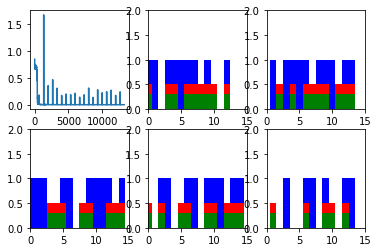

In [8]:
# --- running the graph

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size ))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX ,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

In [0]:
plt.ioff()
plt.show()